In [1]:
#TODO: prettyfy this notebook. All stuff is here except Hicks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint

from consav.linear_interp import interp_1d

In [3]:
# per-period utility
def util(C,h,par):
    return (C**(1+par.eta))/(1+par.eta) - par.beta*(h**(1+par.gamma))/(1+par.gamma)

def cons2(h2,w2,N2,b,par):
    return (1.0-par.tau)*w2*h2 + N2 - (1+par.r)*b

def value_of_choice1(C1,h1,w1,N1,V2,par):
    
    # current period utility
    u1 = util(C1,h1,par)
    
    # implied borrowing
    b = -((1.0-par.tau)*w1*h1 + N1 - C1)
    
    # next-period value of this level of b
    V2_interp = interp_1d(par.b_grid,V2,b)
    
    # discounted value
    return u1 + par.rho*V2_interp

# solution
def solve(w1,w2,N1,N2,par):
    
    # last period
    V2 = np.nan + np.ones(par.b_grid.size)
    h2_vec = np.nan + np.ones(par.b_grid.size)
    h2_init = np.array([20.0])
    for ib,b in enumerate(par.b_grid):
        obj2 = lambda h: -util( cons2(h,w2,N2,b,par) , h,par)
        if ib>0: h2_init = np.array(h2_vec[ib-1])
        
        # constraints: ensure positive consumption
        bounds = ((0.0,200.0),)
        constr = lambda h: cons2(h,w2,N2,b,par) 
        nlc = NonlinearConstraint(constr, lb=0.0, ub=np.inf,keep_feasible=True)
        
        res = minimize(obj2,h2_init,bounds=bounds,constraints=nlc,method='trust-constr')
        h2_vec[ib] = res.x[0]
        V2[ib] = -res.fun
        
        
    # first period
    obj1 = lambda x: -value_of_choice1(x[0],x[1],w1,N1,V2,par)
    init = np.array([1.0,2.0])
    bounds = ((0.0001,2000.0),(0.0,2000.0))

    res = minimize(obj1,init,bounds=bounds,method='trust-constr')
    C1 = res.x[0]
    h1 = res.x[1]
    V1 = -res.fun
    
    return C1,h1,h2_vec

In [4]:
# parameters 
class par: pass
par.beta = 0.1
par.eta = -2.0
par.gamma = 2.5
par.tau = 0.1
par.r = 0.02
par.rho = 1/(1+par.r)

# grid of wealth
par.b_grid = np.linspace(-5.0,5.0,100)

In [5]:
# find optimal labor supply for a given level of wages and non-labor income
w1 = 1.0
w2 = 1.0
N1 = 0.0 # non-labor income. Important for strength of income effect
N2 = 0.0 # non-labor income. Important for strength of income effect
C1,h1,h2_vec = solve(w1,w2,N1,N2,par)

C:\Users\bnl429\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


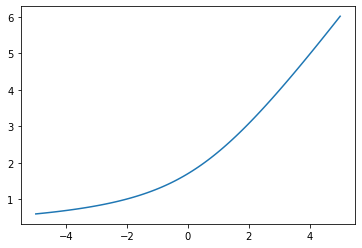

In [6]:
plt.plot(par.b_grid,h2_vec);

In [7]:
# consumption should be rather constant across periods for this parametrization
b = -((1.0-par.tau)*w1*h1 + N1 - C1)
h2 = interp_1d(par.b_grid,h2_vec,b)
C2 = cons2(h2,w2,N2,b,par)
print(f'C1={C1:2.3f}, C2={C2:2.3f}')

C1=1.537, C2=1.537


In [8]:
# Marshall elasticity
# theoretical (when rho=1/(1+r) and N1=N2=0)
ela_M = (1+par.eta) / (par.gamma - par.eta)

# simulate permanent increase
C1_,h1_1pct,h2_ = solve(w1*1.01,w2*1.01,N1,N2,par)
ela_M1_sim = (h1_1pct-h1)/h1*100

print(f'e_M={ela_M:2.3f}, e_M1_sim={ela_M1_sim:2.3f}')

C:\Users\bnl429\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


e_M=-0.222, e_M1_sim=-0.221


In [9]:
# Frisch elasticity
ela_F = 1/par.gamma

# simulate transitory increase
C1_,h1_F,h2_ = solve(w1*1.01,w2,N1,N2,par)
ela_F1_sim = (h1_F-h1)/h1*100

print(f'e_F={ela_F:2.3f}, e_F1_sim={ela_F1_sim:2.3f}')

C:\Users\bnl429\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


e_F=0.400, e_F1_sim=0.399


In [ ]:
# Hicks
ela_H = 1/(par.gamma - par.eta)

# compensate...